## Fwrf semantic model, 2014 imagery.rf data
Using robust validation procedure.


In [1]:
import numpy as np
import pandas as pd
import h5py
import nibabel as nib
import matplotlib.pyplot as plt
import pickle
from glob import glob
from PIL import Image
from imagery_rf_field.src.glmd_betas import *
from os.path import join
from time import time
from glob import glob
from scipy.io import loadmat
from scipy.stats import pearsonr
from hrf_fitting.src.feature_weighted_rf_models import make_rf_table,receptive_fields, model_space, prediction_menu, bigmult
from hrf_fitting.src.feature_weighted_rf_models import leave_k_out_training, split_em_up
from math import atan2, degrees
from IPython.display import Image as ipyImage

Using gpu device 0: GeForce GTX TITAN X


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Step 0: load data

#### find data files

In [3]:
saving_spot = '/media/tnaselar/Data/scratch/'

####with z-score
# beta_path = '/musc.repo/Data/jesse/imagery_RF/brainthresh99_0_05_with_Zscore/betas/'
# file_exp = '%s_all_runs_BETAs_w_zscore.mat'

####withOUT z-score
beta_path = '/musc.repo/Data/jesse/imagery_RF/brainthresh99_0_05_withOUT_Zscore/betas/'
file_exp = '%s_all_runs_BETAs_no_zs.mat'
subject = 'TN'
stim_loc = '/musc.repo/mri/7T.cmrr/Presentation/imagery.rf.7T.July.2014/'
cond_file_path = '/musc.repo/Data/jesse/imagery_RF/brainthresh99_0_05_withOUT_Zscore/condit_names/%s_condit_names.mat' %(subject)
mask_path = '/media/tnaselar/Data/imagery_rf.2014/masks/%s_mask.nii.gz' %(subject)
state_list = ['img', 'pcp']
print '==============+++++++++========SUBJECT: %s' %(subject)

==============+++++++++========SUBJECT: TN


#### load data

In [4]:
beta_df = load_betas_from_mat_file(join(beta_path,file_exp) %(subject))
mask = load_mask_from_nii(mask_path)

In [5]:
stim_df = load_stim_from_mat_file(cond_file_path,stim_loc)

In [6]:
mask = load_mask_from_nii(mask_path)

In [7]:
print 'volume dimensions: %s' %(mask.shape,)
print 'number of voxels: %d' %(np.sum(mask))

volume dimensions: (130, 130, 70)
number of voxels: 432342


#### instantiate simple class to gather all the data together

In [8]:
fMRI = imagery_rf_dataset(subject, beta_df, stim_df, mask)

#### eyeball description of each condition

In [9]:
fMRI.stim.head(72)

,run,category,object_name,location,image_name
0,1img,vehicle,fire_truck,north,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
1,1img,bird,birds,southeast,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
2,1img,few_humans,baby,east,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
3,1img,few_humans,baby,west,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
4,1img,few_humans,baby,southwest,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
5,1img,many_humans,audience,south,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
6,1img,part_of_building,building,east,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
7,1img,few_humans,baby,northeast,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
8,1img,bird,birds,southwest,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
9,1img,many_humans,audience,northeast,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...


#### look at one of the stimuli

/musc.repo/mri/7T.cmrr/Presentation/imagery.rf.7T.July.2014/imagery_005/frame_files/000718.006.02.image.png
audience
southwest


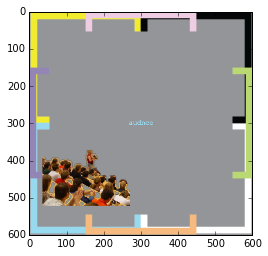

In [10]:
cond_dx = 512
img = fMRI.get_condition_stimuli(cond_dx)
plt.imshow(img)
print fMRI.stim.loc[cond_dx,'image_name']
print fMRI.stim.loc[cond_dx,'object_name']
print fMRI.stim.loc[cond_dx,'location']

#### separate out the imagery and perception indices

In [11]:
idx = {}
idx['img'] = fMRI.get_stimuli_with('run','img').index
idx['pcp'] = fMRI.get_stimuli_with('run','pcp').index


print 'number of imagery stimuli: %d' %(len(idx['img']))
print 'number of perception stimuli: %d' %(len(idx['pcp']))

number of imagery stimuli: 512
number of perception stimuli: 512


### Step 1: semantic feature maps

#### calculate deg_per_stimulus

In [12]:
native_stim_size = 600  ##pixels
viewing_distance = 100 ##cm
viewing_area = 38.8 ##cm
deg_per_stimulus = 21.958 ##deg

# Calculate the number of degrees that correspond to a single pixel. This will
# generally be a very small value, something like 0.03.
deg_per_px = degrees(atan2(.5*viewing_area, viewing_distance)) / (.5*native_stim_size)
print '%f pixels correspond to one degree' % (1./deg_per_px)
# Calculate the size of the stimulus in degrees
size_in_deg = native_stim_size * deg_per_px
print 'The size of the stimulus is %s pixels and %s visual degrees' % (native_stim_size, size_in_deg)



27.324889 pixels correspond to one degree
The size of the stimulus is 600 pixels and 21.958003465 visual degrees


   #### load up images

In [13]:
max_feature_res = 256
load_stim_func = lambda dx: np.array(fMRI.get_condition_stimuli(dx,output = 'PIL',image_size=(max_feature_res,max_feature_res)).convert('L'))[np.newaxis,np.newaxis] 

In [14]:
stimuli = {}
stimuli['pcp'] = np.concatenate(map(load_stim_func,
                                 idx['pcp']),
                             axis=0)

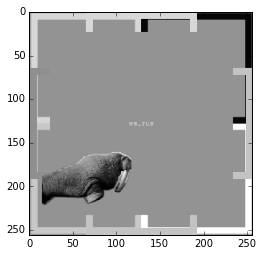

In [15]:
plt.imshow(stimuli['pcp'][64,0,:,:], cmap='gray')

In [16]:
stimuli['img'] = np.concatenate(map(load_stim_func,
                                 idx['img']),
                             axis=0)

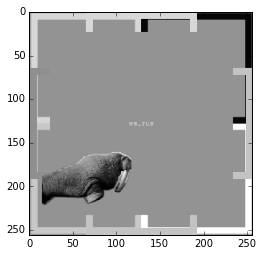

In [17]:
plt.imshow(stimuli['img'][64,0,:,:],cmap='gray')

#### convert images to apertures

In [18]:
for state in state_list:
    for ii,stim in enumerate(stimuli[state]):
        cue_idx = idx[state][ii]
        cue_file = fMRI.stim.loc[cue_idx, 'image_name'].replace('.image.', '.cue.')
        cue_img = np.array(Image.open(cue_file).resize((max_feature_res,max_feature_res)).convert('L'))
        stim[0] -= cue_img        
        stim **= (1 - (stim>0).astype('uint8'))
        

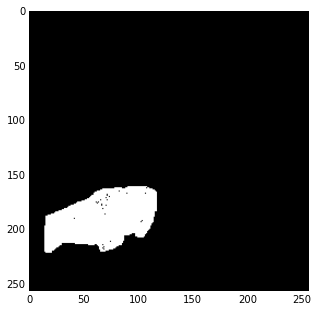

In [19]:
plt.figure(figsize=(5,5))
plt.imshow(stimuli['pcp'][64,0,:,:],cmap='gray')

#### categorize into semantic feature maps

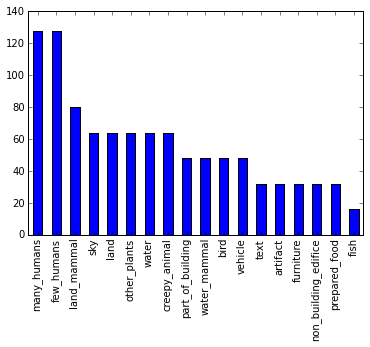

In [20]:
fMRI.stim['category'].value_counts().plot(kind='bar')


In [21]:
feature_dict = {}

category_names = fMRI.stim['category'].unique()
for state in state_list:
    feature_dict[state] = {}
    for category in category_names:
        feature_dict[state][category] = np.zeros((len(idx[state]), 1, max_feature_res, max_feature_res),dtype='float32')
    for ii,stim in enumerate(stimuli[state]):
        cat_idx = idx[state][ii]
        category = fMRI.stim.loc[cat_idx,'category']
        feature_dict[state][category][ii] = stim

    

water_mammal
float32


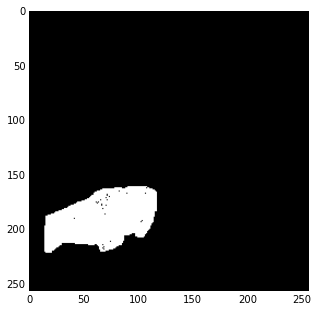

In [22]:
dx = 64
state = 'pcp'
category = fMRI.stim.loc[idx[state][dx],'category']
plt.figure(figsize=(5,5))
plt.imshow(feature_dict[state][category][dx, 0, :, :],cmap='gray')
print category
print feature_dict[state][category][dx, 0, :, :].dtype

### Step 2: Design receptive field grid

In [23]:
deg_per_radius = (1., 9., 4) ##rf sizes in degrees (smallest, largest, number of sizes)
spacing = 3.2 ##spacing between rf's in degrees
rf = receptive_fields(deg_per_stimulus,deg_per_radius,spacing)

In [24]:
rf.rf_table.deg_per_radius.unique()

array([ 1.        ,  3.66666667,  6.33333333,  9.        ])

In [25]:
print 'G = number of rf models = %d' %(rf.rf_table.shape[0])

G = number of rf models = 144


### Step 3: Construct a model space

#### specify activation function

In [26]:
def log_act_func(x):
    return np.log(1+np.sqrt(x))


#### instantiate model space object for each state

In [27]:
ms = {}
for state in state_list:
    ms[state] = model_space(feature_dict[state], rf, activation_function = log_act_func)


### Step 5: train the perception and imagery models

#### train/test split

In [28]:
val_frac = 0.04687  ##24
nvox = fMRI.betas.shape[0]
n_resamples = 10 ##for a total of 240 validation samples

#### train the model!

In [29]:
mst = {}
params = {}
pred = {}
val_cc = {}
val_idx = {}
trn_idx = {}
for state in state_list: #[pcp', 'img']:
    params[state] = {}
    print '==========================================================%s' %(state)
    ##build model space tensor
    mst[state] = ms[state].construct_model_space_tensor(feature_dict[state], normalize=False)
    mst[state] = ms[state].normalize_model_space_tensor(mst[state],save=True)
    voxel_data = fMRI.betas[0:nvox, idx[state]].T
    val_idx[state] = split_em_up(len(idx[state]),val_frac,n_resamples)
    

    trn_idx[state], params[state] = leave_k_out_training(val_idx[state],
                                                         mst[state],
                                                         voxel_data,
                                                         initial_feature_weights='zeros',
                                                         voxel_binsize = 25000,
                                                         rf_grid_binsize=10,
                                                         learning_rate=10**(-5.),
                                                         max_iters = 75,
                                                         early_stop_fraction=0.05,
                                                         report_every = 25)
    ##generate predictions
    Tval = len(val_idx[state][0])
    pred[state] = np.zeros((Tval*n_resamples,nvox))
    val_cc[state] = np.zeros(nvox)

    for val_iter in val_idx[state].keys():
        frf = params[state][val_iter]['frf']
        ffw = params[state][val_iter]['ffw']
        
        for v in range(nvox): 
            pred[state][(val_iter*Tval):(val_iter*Tval+Tval),v] = np.squeeze(bigmult(mst[state][np.newaxis,frf[v],val_idx[state][val_iter],:],
                                           ffw[np.newaxis,:,v, np.newaxis]))
    
    total_val_idx = np.concatenate(val_idx[state].values()).astype('int')    
    for v in range(nvox): 
        val_cc[state][v] = np.nan_to_num(pearsonr(voxel_data[total_val_idx,v],pred[state][:,v])[0])

==========================================================img
-----------feature: non_building_edifice
-----------feature: land
-----------feature: prepared_food
-----------feature: part_of_building
-----------feature: text
-----------feature: fish
-----------feature: vehicle
-----------feature: sky
-----------feature: land_mammal
-----------feature: water_mammal
-----------feature: water
-----------feature: creepy_animal
-----------feature: other_plants
-----------feature: artifact
-----------feature: many_humans
-----------feature: few_humans
-----------feature: bird
-----------feature: furniture
normalization constants have been saved
converted nans to nums
model_space_tensor has been z-scored
number of validation samples: 24
number of data samples: 512
======beginning training round 0
--------------voxels from 0 to 27021
--------candiate rf models 0 to 11
-------
errors: 15080.358624
change in best rf: 146950.000000
norm of feature weights: 26.450632
improvements: 297231
0.14701604

#### save it

In [30]:
saving_place = '/media/tnaselar/Data/imagery_rf.2014/model_runs/'

for ii,state in enumerate(state_list):
    saving_file = 'model_space_'+'fwrf_semantic_robust_'+state+'_'+subject+'.p'
    ms[state].params = params[state]
    ms[state].val_cc = val_cc[state]
#     ms[state].activation_function = act_func
    pickle.dump(ms[state], open( join(saving_place, saving_file), "wb"))

### Step 6: analysis

#### loss history

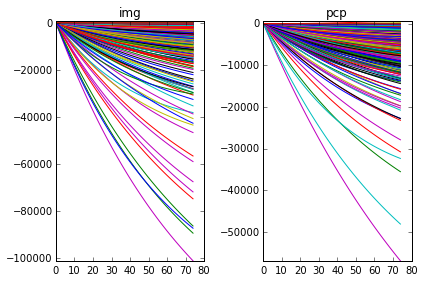

In [31]:
skip = 10
for ii,state in enumerate(state_list):
    beh = params[state][0]['beh']
    plt.subplot(1,2,ii+1)
    plt.title(state)
    diff = beh[:,slice(0,-1,skip)]-beh[0,slice(0,-1,skip)]
    _=plt.plot(diff)
    plt.ylim([np.min(diff.ravel()),np.max(diff.ravel())])
plt.tight_layout()

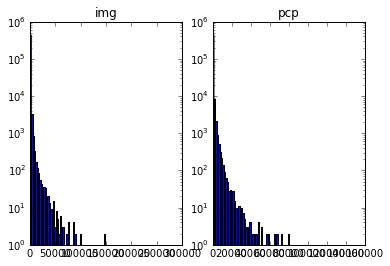

In [32]:
for ii,state in enumerate(state_list):
    beh = params[state][0]['beh']
    plt.subplot(1,2,ii+1)
    plt.title(state)
    _=plt.hist(np.nan_to_num(beh[0,:]-np.min(beh,axis=0)),100)
    plt.yscale('log')

#### rf's

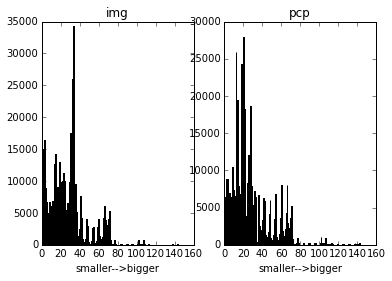

In [33]:
for ii,state in enumerate(state_list):
    frf = params[state][0]['frf']
    plt.subplot(1,2,ii+1)
    _=plt.hist(frf,ms[state].receptive_fields.G)
    plt.xlabel('smaller-->bigger')
    plt.title(state)

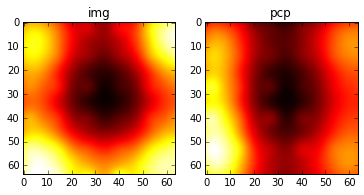

In [34]:
for ii,state in enumerate(state_list):
    frf = params[state][0]['frf']
    plt.subplot(1,2,ii+1)
    plt.title(state)
    plt.imshow(np.sum(ms[state].receptive_fields.make_rf_stack(64, min_pix_per_radius=1)[frf,:,:], axis=0), cmap='hot')

#### prediction accuracy histograms

In [35]:
####USE THIS TO LOAD UP A SAVED MST FOR VAL_CC ANALYSIS
# saving_place = '/media/tnaselar/Data/imagery_rf.2014/model_runs/'
# mst={}
# for ii,state in enumerate(['pcp','img']):
#     saving_file = 'model_space_'+'fwrf_semantic_robust_'+state+'_'+'CO'+'.p'
#     mst[state]=pickle.load(open( join(saving_place, saving_file), "r"))
    
# val_cc['pcp'] = mst['pcp'].val_cc
# val_cc['img'] = mst['img'].val_cc

number of voxels with cc > 0.250000, img: 539
number of voxels with cc > 0.250000, pcp: 5781


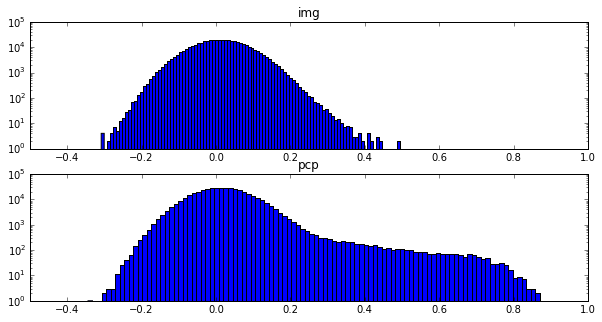

In [36]:

count_thresh = .25
plt.figure(figsize = (10,5))
for ii,state in enumerate(state_list):#, 'img']):
    plt.subplot(2,1,ii+1)
    _=plt.hist(val_cc[state],100)
    plt.yscale('log')
    plt.ylim([10**0, 10**5])
    plt.xlim([-.5, 1.])
    plt.title(state)
    print 'number of voxels with cc > %f, %s: %d' %(count_thresh,state,np.sum(map(lambda x: x > count_thresh, val_cc[state])))

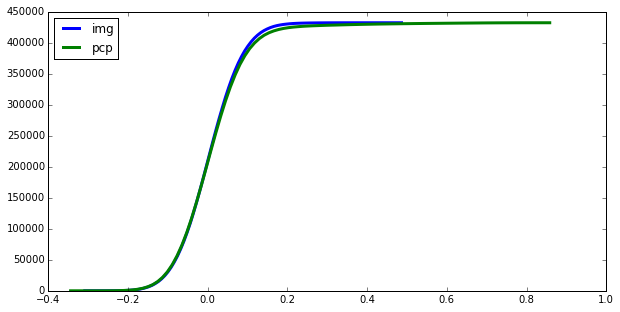

In [37]:
plt.figure(figsize = (10,5))
for ii,state in enumerate(state_list):
    values, base = np.histogram(val_cc[state], bins=100)
    #evaluate the cumulative
    cumulative = np.cumsum(values)
    # plot the cumulative function
    plt.plot(base[:-1], cumulative, hold=True,label=state, linewidth=3)#     plt.yscale('log')
#     plt.ylim([10**0, 10**4])
#     plt.xlim([-1, 1.])
    
plt.legend(loc='best')    

#### prediction accuracy head-to-head

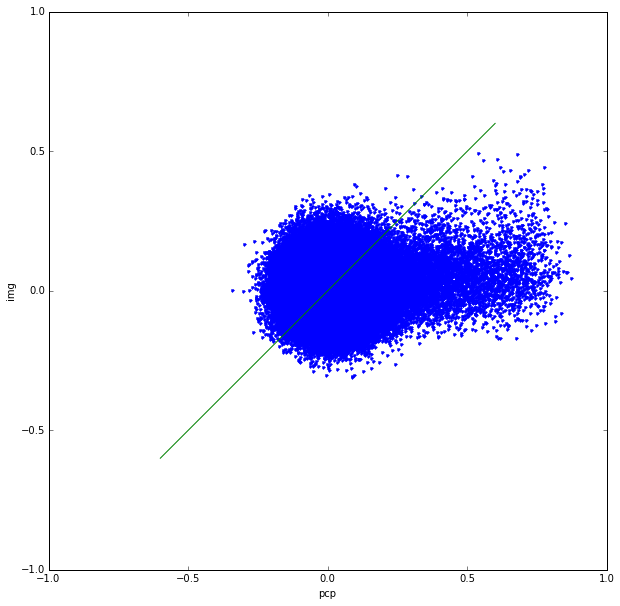

In [38]:
if ('pcp' in state_list) & ('img' in state_list):
    plt.figure(figsize=(10,10))
    rng = np.linspace(-.6, .6, num=50)
    plt.plot(val_cc['pcp'], val_cc['img'], '.');
    plt.ylabel('img')
    plt.xlabel('pcp')
    plt.plot(rng, rng)
    plt.axes().set_aspect(1)
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])

#### prediction accuracy volumes

In [39]:
def view_vol_data(data_object, data_vol,save_to = None):
    cur = data_object.mask.ravel(order=data_object.order).copy()
    cur[cur > 0] = data_vol
    view_vol = cur.reshape(data_object.shape,order=data_object.order)
    if save_to:
        nib.save(nib.Nifti1Image(view_vol,affine=np.eye(4)),save_to)
    else:
        return view_vol

In [40]:
for state in state_list:
    view_vol_data(fMRI,val_cc[state], save_to = '/media/tnaselar/Data/scratch/'+state+'_semantic_val_cc_'+subject )

In [41]:
# ipyImage(filename='/home/tnaselar/Dropbox/Manuscripts/imagery.receptive.fields/First.try.pcp.val_cc.TN.png')

In [42]:
# ipyImage(filename='/home/tnaselar/Dropbox/Manuscripts/imagery.receptive.fields/First.imagery.val_cc.TN.png')